<a href="https://colab.research.google.com/github/zhouhb0321/training-your-own/blob/main/Train_Your_Own_Chess%C2%A0AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install peewee pytorch-lightning
!wget https://storage.googleapis.com/chesspic/datasets/2021-07-31-lichess-evaluations-37MM.db.gz
!gzip -d "2021-07-31-lichess-evaluations-37MM.db.gz"
!rm "2021-07-31-lichess-evaluations-37MM.db.gz"

     |████████████████████████████████| 2.3 MB 14.9 MB/s 
     |████████████████████████████████| 916 kB 63.9 MB/s 
     |████████████████████████████████| 636 kB 60.0 MB/s 
     |████████████████████████████████| 118 kB 77.5 MB/s 
     |████████████████████████████████| 272 kB 63.9 MB/s 
     |████████████████████████████████| 829 kB 60.0 MB/s 
     |████████████████████████████████| 1.3 MB 61.3 MB/s 
     |████████████████████████████████| 294 kB 54.3 MB/s 
     |████████████████████████████████| 142 kB 65.8 MB/s 
  Created wheel for peewee: filename=peewee-3.14.4-cp37-cp37m-linux_x86_64.whl size=593000 sha256=9c76d594032779ec9e3b1af598525dbec94d8d07d159ff65cc4ea10aa0b662d1
  Stored in directory: /root/.cache/pip/wheels/c5/5e/9f/63055772274c6b22b94cf2081d698d64ecfcdc78396109be83
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a0f74f778fb2e13d71d2d3cd2740923bd0981f3ab20529b4d9b3284c3300113c
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/

In [ ]:
from peewee import *
import base64

db = SqliteDatabase('2021-07-31-lichess-evaluations-37MM.db')

class Evaluations(Model):
  id = IntegerField()
  fen = TextField()
  binary = BlobField()
  eval = FloatField()

  class Meta:
    database = db

  def binary_base64(self):
    return base64.b64encode(self.binary)
db.connect()
LABEL_COUNT = 37164639
print(LABEL_COUNT)
eval = Evaluations.get(Evaluations.id == 1)
print(eval.binary_base64())

37164639
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
import pytorch_lightning as pl
from random import randrange

class EvaluationDataset(IterableDataset):
  def __init__(self, count):
    self.count = count
  def __iter__(self):
    return self
  def __next__(self):
    idx = randrange(self.count)
    return self[idx]
  def __len__(self):
    return self.count
  def __getitem__(self, idx):
    eval = Evaluations.get(Evaluations.id == idx+1)
    bin = np.frombuffer(eval.binary, dtype=np.uint8)
    bin = np.unpackbits(bin, axis=0).astype(np.single) 
    eval.eval = max(eval.eval, -15)
    eval.eval = min(eval.eval, 15)
    ev = np.array([eval.eval]).astype(np.single) 
    return {'binary':bin, 'eval':ev}    

dataset = EvaluationDataset(count=LABEL_COUNT)

In [ ]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
import time
from collections import OrderedDict

class EvaluationModel(pl.LightningModule):
  def __init__(self,learning_rate=1e-3,batch_size=1024,layer_count=10):
    super().__init__()
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    layers = []
    for i in range(layer_count-1):
      layers.append((f"linear-{i}", nn.Linear(808, 808)))
      layers.append((f"relu-{i}", nn.ReLU()))
    layers.append((f"linear-{layer_count-1}", nn.Linear(808, 1)))
    self.seq = nn.Sequential(OrderedDict(layers))

  def forward(self, x):
    return self.seq(x)

  def training_step(self, batch, batch_idx):
    x, y = batch['binary'], batch['eval']
    y_hat = self(x)
    loss = F.l1_loss(y_hat, y)
    self.log("train_loss", loss)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def train_dataloader(self):
    dataset = EvaluationDataset(count=LABEL_COUNT)
    return DataLoader(dataset, batch_size=self.batch_size, num_workers=2, pin_memory=True)

configs = [
           {"layer_count": 4, "batch_size": 512},
          #  {"layer_count": 6, "batch_size": 1024},
           ]
for config in configs:
  version_name = f'{int(time.time())}-batch_size-{config["batch_size"]}-layer_count-{config["layer_count"]}'
  logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
  trainer = pl.Trainer(gpus=1,precision=16,max_epochs=1,auto_lr_find=True,logger=logger)
  model = EvaluationModel(layer_count=config["layer_count"],batch_size=config["batch_size"],learning_rate=1e-3)
  # trainer.tune(model)
  # lr_finder = trainer.tuner.lr_find(model, min_lr=1e-6, max_lr=1e-3, num_training=25)
  # fig = lr_finder.plot(suggest=True)
  # fig.show()
  trainer.fit(model)
  break

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 2.0 M 
------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.847     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."


Training: -1it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff37d94b8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff37d94b8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Idx 4399257 Eval 5.03 Prediction -1.11 Loss 6.14
FEN 2r1r2k/4nBp1/p2B1pPp/Pp2pP1P/3pP3/3P4/2P5/2R4K w - - 7 42


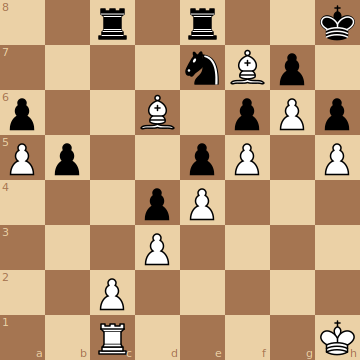

Idx 23277470 Eval 0.09 Prediction -0.56 Loss 0.65
FEN r2qk2r/pp2nppp/2pBp3/3p4/3Pn3/Q3P2P/PPP2PP1/RN2K2R w KQkq - 9 14


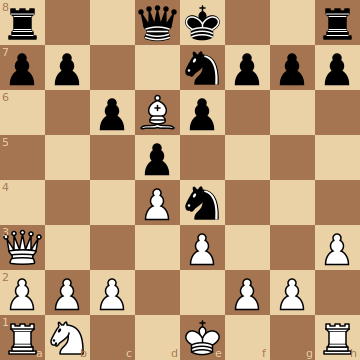

Idx 23711247 Eval 1.88 Prediction 0.07 Loss 1.81
FEN 2r1k2r/pp1bppb1/2np1np1/q6p/3NP3/2N1BP1P/PPPQB1P1/1K1R3R b k - 3 12


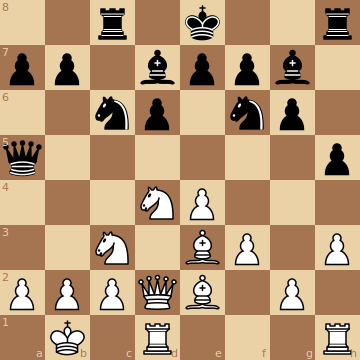

Idx 32152355 Eval 1.05 Prediction 1.80 Loss 0.75
FEN r1bqkbnr/ppp1p1pp/2np1p2/8/2PP4/2N1P3/PP3PPP/R1BQKBNR b KQkq - 0 4


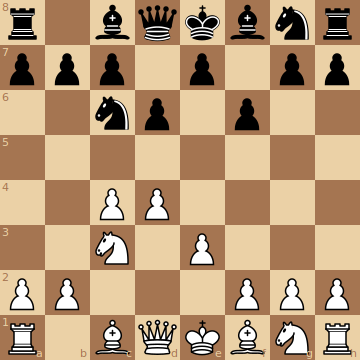

Idx 3786920 Eval 0.61 Prediction 0.07 Loss 0.54
FEN r1bqk2r/ppp1ppb1/2np1npp/8/3P1B1P/2N2N2/PPPQPPP1/R3KB1R w KQkq - 1 7


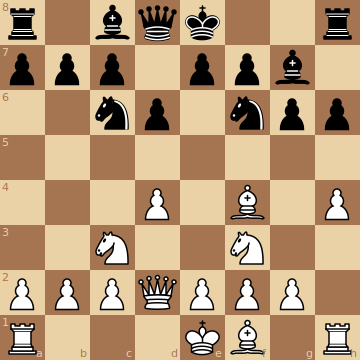

In [ ]:
from IPython.display import display, SVG
from random import randrange

SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/" 

def svg_url(fen):
  fen_board = fen.split()[0]
  return SVG_BASE_URL + fen_board

def show_index(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  display(SVG(url=svg_url(eval.fen)))

for i in range(5):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

# need to do better on "tactics" like 700756

In [ ]:
import chess

MATERIAL_LOOKUP = {chess.KING:0,chess.QUEEN:9,chess.ROOK:5,chess.BISHOP:3,chess.KNIGHT:3,chess.PAWN:1}

def avg(lst):
    return sum(lst) / len(lst)

def material_for_board(board):
  eval = 0.0
  for sq, piece in board.piece_map().items():
    mat = MATERIAL_LOOKUP[piece.piece_type] 
    if piece.color == chess.BLACK:
      mat = mat * -1
    eval += mat
  return eval
  
def guess_zero_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  y = torch.tensor(eval.eval)
  y_hat = torch.zeros_like(y)
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_material_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  board = chess.Board(eval.fen)
  y = torch.tensor(eval.eval)
  y_hat = torch.tensor(material_for_board(board))
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_model_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  return loss

zero_losses = []
mat_losses = []
model_losses = []
for i in range(100):
  idx = randrange(LABEL_COUNT)
  zero_losses.append(guess_zero_loss(idx))
  mat_losses.append(guess_material_loss(idx))
  model_losses.append(guess_model_loss(idx))
print(f'Guess Zero Avg Loss {avg(zero_losses)}')
print(f'Guess Material Avg Loss {avg(mat_losses)}')
print(f'Guess Model Avg Loss {avg(model_losses)}')

Guess Zero Avg Loss 7.7659010887146
Guess Material Avg Loss 5.943099498748779
Guess Model Avg Loss 1.9809308052062988
